In [21]:
import ee
import geemap
from geemap import ml
from sklearn import ensemble
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Inicializa la autenticación y la inicialización de Google Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-facuboladerasgee')

In [26]:
import os

def combine_csv_files(folder_path):
    # Lista para almacenar todos los DataFrames
    df_list = []
    
    # Recorrer todos los archivos en la carpeta
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            # Leer cada archivo CSV y agregarlo a la lista
            df = pd.read_csv(file_path)
            df_list.append(df)
    
    # Combinar todos los DataFrames en uno solo
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df

# Ejemplo de uso
folder_path = 'C://Users//Facu//Downloads//Nepal_datos'
combined_df = combine_csv_files(folder_path)
combined_df.to_csv("RF_nepal_data.csv", index=False)

In [27]:
# Calcular la nueva columna 'threshold'
# Calcular la nueva columna 'threshold'
combined_df['threshold'] = (combined_df['agbd_se'] / combined_df['agbd']) * 100
# combined_df = combined_df.loc[combined_df['Slope'] <= 25]

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  2930 non-null   int64  
 1   B11           2930 non-null   float64
 2   B12           2930 non-null   float64
 3   B2            2930 non-null   float64
 4   B3            2930 non-null   float64
 5   B4            2930 non-null   float64
 6   CH            2930 non-null   float64
 7   MNDWI         2930 non-null   float64
 8   NDBI          2930 non-null   float64
 9   NDVI          2930 non-null   float64
 10  RVI           2930 non-null   float64
 11  VH_iqr        2930 non-null   float64
 12  VV_VH_div_2   2930 non-null   float64
 13  VV_div_VH     2930 non-null   float64
 14  VV_iqr        2930 non-null   float64
 15  VV_minus_VH   2930 non-null   float64
 16  VV_plus_VH    2930 non-null   float64
 17  agbd          2930 non-null   float64
 18  agbd_se       2930 non-null 

In [28]:
# Filtrar los datos cuyo valor en la columna 'threshold' sea menor que 50
df_filtered = combined_df[combined_df['threshold'] < 50]

# Mostrar las primeras filas del DataFrame filtrado para verificar
df_filtered.describe()

,system:index,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,...,VV_VH_div_2,VV_div_VH,VV_iqr,VV_minus_VH,VV_plus_VH,agbd,agbd_se,elevation,slope,threshold
count,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,...,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000
mean,55.079044,2013.876838,1177.156250,404.444853,639.541360,531.227022,14.803309,-0.521359,-0.106142,0.653446,...,0.082441,4.417429,0.096271,0.103814,0.164883,65.111234,17.129239,196.213235,4.407622,31.749443
std,44.687901,360.481186,370.479024,135.246139,171.949513,239.281151,3.998608,0.050941,0.092041,0.116235,...,0.019123,0.681160,0.070836,0.028452,0.038246,35.648490,0.005664,72.132159,6.109873,11.298739
min,0.000000,748.000000,291.000000,194.000000,282.000000,181.000000,3.000000,-0.644363,-0.355595,0.188899,...,0.030378,2.665147,0.034292,0.037154,0.060756,34.270410,17.120020,97.000000,0.000000,6.448560
25%,19.000000,1778.875000,927.875000,321.750000,532.750000,367.000000,12.000000,-0.559258,-0.165654,0.584405,...,0.069879,3.920587,0.068808,0.084334,0.139758,40.864054,17.125776,147.000000,1.394084,23.746280
50%,41.000000,1958.500000,1098.500000,373.000000,609.000000,465.500000,15.000000,-0.522239,-0.107389,0.678786,...,0.082443,4.392598,0.082262,0.103115,0.164886,53.186756,17.128448,180.500000,2.783716,32.211825
75%,84.000000,2212.375000,1360.250000,446.750000,695.000000,618.125000,17.000000,-0.491301,-0.043725,0.744302,...,0.093926,4.876137,0.099784,0.120200,0.187853,72.194707,17.131550,225.000000,4.249850,41.923333
max,198.000000,3742.000000,3231.000000,1567.000000,2081.000000,2299.000000,27.000000,-0.285248,0.176218,0.852081,...,0.224752,7.550619,0.795355,0.299327,0.449504,265.544600,17.160654,513.000000,45.936745,49.986630


In [31]:
def remove_outliers(df, column_name):

    # Calcular la media y la desviación estándar de la columna
    mean = df[column_name].mean()
    std_dev = df[column_name].std()
    
    # Calcular el umbral para identificar los outliers
    threshold = 4 * std_dev
    
    # Crear una condición para filtrar los outliers
    condition = (df[column_name] >= (mean - threshold)) & (df[column_name] <= (mean + threshold))
    
    # Crear un nuevo DataFrame con los outliers eliminados
    df_filtered = df[condition]
    
    return df_filtered

# Ejemplo de uso
# Supongamos que tienes un DataFrame llamado df_combined con una columna "agbd"
# df_combined = pd.read_csv("ruta_a_tu_csv.csv")

df_filtered_remove = remove_outliers(df_filtered, "agbd")

# Mostrar las primeras filas del DataFrame filtrado
df_filtered_remove

,system:index,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,...,VV_div_VH,VV_iqr,VV_minus_VH,VV_plus_VH,agbd,agbd_se,elevation,slope,.geo,threshold
9,9,1264.0,614.0,322.0,468.0,307.0,18.0,-0.459584,-0.355595,0.792987,...,3.270132,0.061111,0.069483,0.130698,66.713720,17.131804,148.0,5.069983,"{""geodesic"":false,""type"":""Point"",""coordinates""...",25.679581
10,10,1329.0,643.0,343.0,478.0,331.0,17.0,-0.470946,-0.339791,0.781374,...,2.865100,0.058396,0.071832,0.148859,125.593150,17.121190,151.0,0.000000,"{""geodesic"":false,""type"":""Point"",""coordinates""...",13.632264
11,11,1638.0,752.0,274.0,535.0,330.0,16.0,-0.507593,-0.273292,0.793750,...,3.387081,0.051264,0.073249,0.134621,123.101520,17.121433,149.0,8.841494,"{""geodesic"":false,""type"":""Point"",""coordinates""...",13.908385
12,12,1563.0,745.0,388.0,590.0,394.5,15.0,-0.451928,-0.306412,0.763666,...,2.692354,0.046401,0.066746,0.145625,159.243470,17.120398,141.0,7.666639,"{""geodesic"":false,""type"":""Point"",""coordinates""...",10.751083
14,14,2100.0,1190.0,367.0,509.0,432.0,15.0,-0.609812,0.039090,0.636057,...,5.007036,0.137728,0.141673,0.212386,84.262825,17.123537,142.0,12.330949,"{""geodesic"":false,""type"":""Point"",""coordinates""...",20.321580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,89,1805.0,905.5,317.5,575.0,398.0,21.0,-0.516807,-0.168682,0.728837,...,4.580584,0.069887,0.125401,0.195446,147.927920,17.120663,185.0,1.393885,"{""geodesic"":false,""type"":""Point"",""coordinates""...",11.573652
2924,90,1753.5,858.0,306.5,580.0,333.5,18.0,-0.502893,-0.157680,0.756880,...,4.508984,0.075038,0.116087,0.182253,127.084740,17.121141,185.0,0.000000,"{""geodesic"":false,""type"":""Point"",""coordinates""...",13.472224
2925,91,1751.0,790.0,322.0,577.0,326.0,17.0,-0.504296,-0.188413,0.774394,...,4.994258,0.076749,0.155494,0.233353,68.512240,17.126316,186.0,2.126092,"{""geodesic"":false,""type"":""Point"",""coordinates""...",24.997454
2926,92,1739.0,850.5,372.5,615.0,363.0,17.0,-0.477485,-0.188994,0.750730,...,5.348107,0.079874,0.131955,0.192651,106.897156,17.121944,186.0,0.000000,"{""geodesic"":false,""type"":""Point"",""coordinates""...",16.017212


In [74]:
df_nuevo = df_filtered_remove[df_filtered_remove['agbd'] <= 180]
df_nuevo.info()
label = df_nuevo['agbd']

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 57 to 11852
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  2525 non-null   int64  
 1   B11           2525 non-null   float64
 2   B12           2525 non-null   float64
 3   B2            2525 non-null   float64
 4   B3            2525 non-null   float64
 5   B4            2525 non-null   float64
 6   CH            2525 non-null   float64
 7   MNDWI         2525 non-null   float64
 8   NDBI          2525 non-null   float64
 9   NDVI          2525 non-null   float64
 10  RVI           2525 non-null   float64
 11  VH            2525 non-null   float64
 12  VV            2525 non-null   float64
 13  VV_VH_div_2   2525 non-null   float64
 14  VV_div_VH     2525 non-null   float64
 15  VV_minus_VH   2525 non-null   float64
 16  VV_plus_VH    2525 non-null   float64
 17  agbd          2525 non-null   float64
 18  agbd_se       2525 non-null   f

In [20]:
# df_proces = df_filtered_remove[~df_filtered_remove['label'].isin([2, 6])]
# df_proces

In [33]:
def drop_columns(df, columns_to_drop):
    return df.drop(columns=columns_to_drop)

columns_to_drop = ['threshold', 'agbd_se','.geo','system:index']
df_modified = drop_columns(df_filtered_remove, columns_to_drop)
df_modified.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542 entries, 9 to 2927
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   B11          542 non-null    float64
 1   B12          542 non-null    float64
 2   B2           542 non-null    float64
 3   B3           542 non-null    float64
 4   B4           542 non-null    float64
 5   CH           542 non-null    float64
 6   MNDWI        542 non-null    float64
 7   NDBI         542 non-null    float64
 8   NDVI         542 non-null    float64
 9   RVI          542 non-null    float64
 10  VH_iqr       542 non-null    float64
 11  VV_VH_div_2  542 non-null    float64
 12  VV_div_VH    542 non-null    float64
 13  VV_iqr       542 non-null    float64
 14  VV_minus_VH  542 non-null    float64
 15  VV_plus_VH   542 non-null    float64
 16  agbd         542 non-null    float64
 17  elevation    542 non-null    float64
 18  slope        542 non-null    float64
dtypes: float64(1

In [35]:
# Obtener los nombres de las columnas excepto 'agbd' y '.geo'
features = [col for col in df_modified.columns if col not in ['agbd', 'label','.geo', 'system:index']]

# Mostrar la lista de características
print(features)

['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH_iqr', 'VV_VH_div_2', 'VV_div_VH', 'VV_iqr', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']


In [36]:
features =  ['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH_iqr', 'VV_VH_div_2', 'VV_div_VH', 'VV_iqr', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']


df_modified_2 = df_modified[features]
df_modified_2.describe()


,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,RVI,VH_iqr,VV_VH_div_2,VV_div_VH,VV_iqr,VV_minus_VH,VV_plus_VH,elevation,slope
count,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000,542.000000
mean,2015.081181,1178.607934,404.800738,639.845941,531.625461,14.767528,-0.521425,-0.105650,0.653145,3.249740,0.021390,0.082210,4.415943,0.094779,0.103489,0.164420,195.201107,4.270413
std,360.444038,370.354194,135.353610,172.161779,239.565706,3.962091,0.051023,0.091832,0.116315,0.094605,0.011698,0.018139,0.681902,0.066234,0.027223,0.036279,70.305921,5.680539
min,748.000000,291.000000,194.000000,282.000000,181.000000,3.000000,-0.644363,-0.355595,0.188899,2.908638,0.006095,0.030378,2.665147,0.034292,0.037154,0.060756,97.000000,0.000000
25%,1781.125000,928.375000,322.000000,533.125000,367.250000,12.000000,-0.559348,-0.164585,0.583835,3.186990,0.016287,0.069919,3.919991,0.068730,0.084305,0.139838,147.000000,1.394082
50%,1960.750000,1099.500000,373.750000,609.000000,465.500000,15.000000,-0.522501,-0.106817,0.678372,3.258143,0.019232,0.082443,4.391877,0.082207,0.103115,0.164886,180.000000,2.783523
75%,2213.125000,1360.750000,447.250000,695.000000,620.375000,17.000000,-0.491131,-0.043364,0.744094,3.319160,0.022979,0.093897,4.875091,0.099740,0.120162,0.187794,223.750000,4.246900
max,3742.000000,3231.000000,1567.000000,2081.000000,2299.000000,27.000000,-0.285248,0.176218,0.852081,3.532198,0.158789,0.145737,7.550619,0.795355,0.204706,0.291473,513.000000,39.609844


In [37]:
# Separar la variable objetivo 'agbd'
y = df_modified['agbd']

# Separar las variables independientes (todas excepto 'agbd' y '.geo')
X = df_modified.drop(columns=['agbd'])

X

,B11,B12,B2,B3,B4,CH,MNDWI,NDBI,NDVI,RVI,VH_iqr,VV_VH_div_2,VV_div_VH,VV_iqr,VV_minus_VH,VV_plus_VH,elevation,slope
9,1264.0,614.0,322.0,468.0,307.0,18.0,-0.459584,-0.355595,0.792987,3.063261,0.015932,0.065349,3.270132,0.061111,0.069483,0.130698,148.0,5.069983
10,1329.0,643.0,343.0,478.0,331.0,17.0,-0.470946,-0.339791,0.781374,2.965098,0.015134,0.074430,2.865100,0.058396,0.071832,0.148859,151.0,0.000000
11,1638.0,752.0,274.0,535.0,330.0,16.0,-0.507593,-0.273292,0.793750,3.088232,0.016646,0.067310,3.387081,0.051264,0.073249,0.134621,149.0,8.841494
12,1563.0,745.0,388.0,590.0,394.5,15.0,-0.451928,-0.306412,0.763666,2.916680,0.024102,0.072813,2.692354,0.046401,0.066746,0.145625,141.0,7.666639
14,2100.0,1190.0,367.0,509.0,432.0,15.0,-0.609812,0.039090,0.636057,3.334114,0.028579,0.106193,5.007036,0.137728,0.141673,0.212386,142.0,12.330949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,1805.0,905.5,317.5,575.0,398.0,21.0,-0.516807,-0.168682,0.728837,3.283229,0.016269,0.097723,4.580584,0.069887,0.125401,0.195446,185.0,1.393885
2924,1753.5,858.0,306.5,580.0,333.5,18.0,-0.502893,-0.157680,0.756880,3.273913,0.018351,0.091126,4.508984,0.075038,0.116087,0.182253,185.0,0.000000
2925,1751.0,790.0,322.0,577.0,326.0,17.0,-0.504296,-0.188413,0.774394,3.332695,0.017867,0.116677,4.994258,0.076749,0.155494,0.233353,186.0,2.126092
2926,1739.0,850.5,372.5,615.0,363.0,17.0,-0.477485,-0.188994,0.750730,3.369891,0.016588,0.096326,5.348107,0.079874,0.131955,0.192651,186.0,0.000000


In [14]:
feature_names = features =  ['B11', 'B12', 'B2', 'B3', 'B4', 'CH', 'MNDWI', 'NDBI', 'NDVI', 'RVI', 'VH', 'VV', 'VV_VH_div_2', 'VV_div_VH', 'VV_minus_VH', 'VV_plus_VH', 'elevation', 'slope']


label = "agbd"


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [39]:
import numpy as np
rf = RandomForestRegressor(random_state=42)

# Definir el grid de parámetros para buscar
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Entrenar el modelo con los mejores parámetros
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = best_rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')


Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\Facu\anaconda3\envs\Geo\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Root Mean Squared Error: 28.943203824296134
R^2 Score: 0.22419959997109573


In [17]:
rf = RandomForestRegressor(bootstrap= True, max_depth= 15, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=42) 


rf.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf.predict(X_test)

# Calcular las métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

Root Mean Squared Error: 19.9264632766292
R^2 Score: 0.5804654024667193


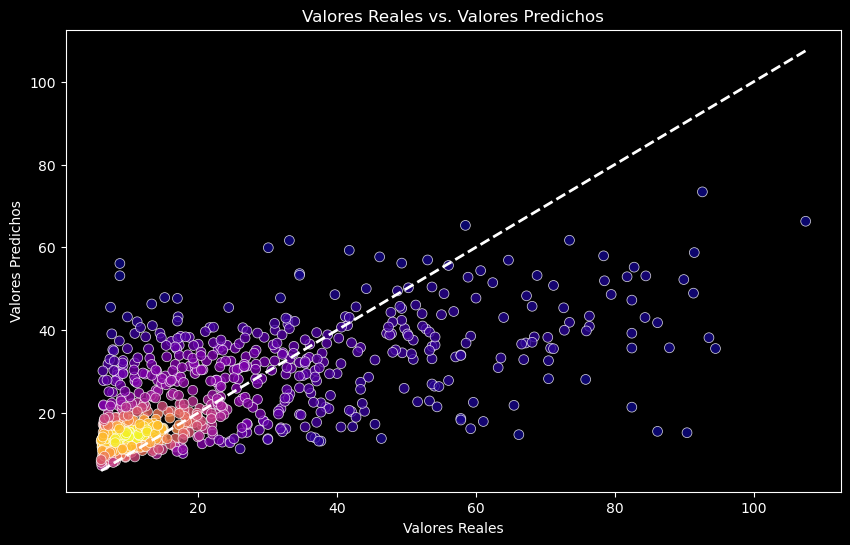

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Calcular la densidad de puntos
xy = np.vstack([y_test, y_pred])
z = gaussian_kde(xy)(xy)

# Crear un gráfico de dispersión con color basado en la densidad de puntos
plt.figure(figsize=(10, 6), facecolor='black')
scatter = plt.scatter(y_test, y_pred, c=z, s=50, cmap='plasma', edgecolor='white', alpha=0.8, linewidth=0.55)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'w--', lw=2)  # Línea de referencia en blanco
plt.xlabel('Valores Reales', color='white')
plt.ylabel('Valores Predichos', color='white')
plt.title('Valores Reales vs. Valores Predichos', color='white')

# Cambiar el color de los ejes y las etiquetas de los ticks
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().xaxis.label.set_color('white')
plt.gca().yaxis.label.set_color('white')
plt.gca().tick_params(axis='x', colors='white')
plt.gca().tick_params(axis='y', colors='white')

# Cambiar el color del fondo del gráfico
plt.gca().set_facecolor('black')

# Guardar el gráfico
plt.savefig('real_vs_predicho2.png', facecolor='black')

# Mostrar el gráfico
plt.show()


        Feature  Importance
7          NDBI    0.133203
5            CH    0.125315
16    elevation    0.100693
6         MNDWI    0.071450
17        slope    0.071378
8          NDVI    0.056556
14  VV_minus_VH    0.055975
11           VV    0.048346
9           RVI    0.048134
1           B12    0.044567
13    VV_div_VH    0.041335
0           B11    0.037897
10           VH    0.037745
2            B2    0.033777
3            B3    0.028510
4            B4    0.026097
12  VV_VH_div_2    0.019595
15   VV_plus_VH    0.019428


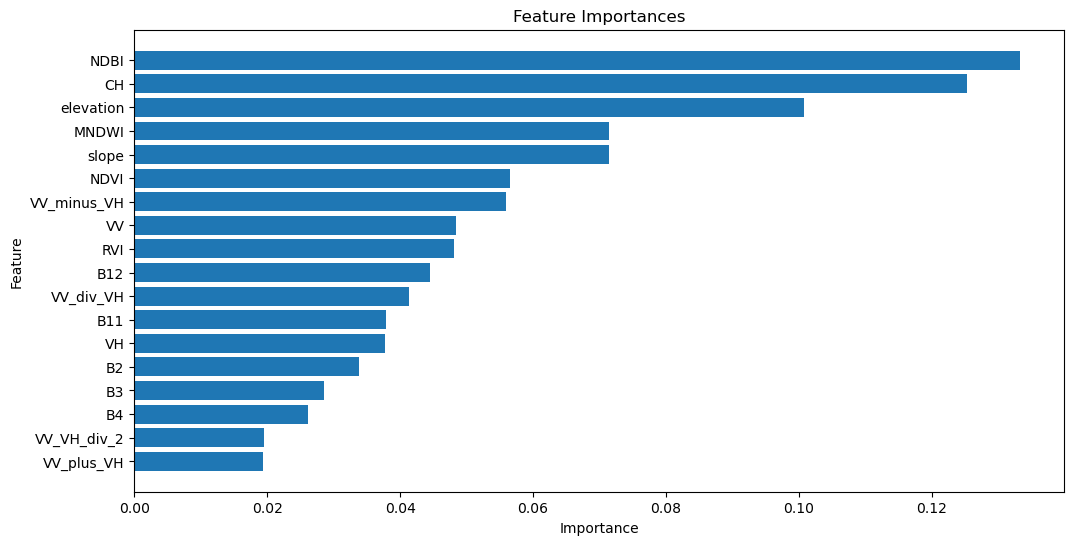

In [18]:
import matplotlib.pyplot as plt
# Obtener la importancia de las características
feature_importances = best_rf.feature_importances_

# Crear un DataFrame para organizar las importancias de las características
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar el DataFrame por importancia
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Mostrar las importancias de las características
print(feature_importances_df)

# Graficar las importancias de las características
plt.figure(figsize=(12, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [19]:
# convert the estimator into a list of strings
# this function also works with the ensemble.ExtraTrees estimator
trees = ml.rf_to_strings(rf, feature_names,output_mode='regression')
# print the first tree to see the result
# print(trees[0])

In [32]:
# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)
# ee_classifier.getInfo()

In [20]:
user_id = 'users/facuboladerasgee'
# specify asset id where to save trees
# be sure to change  to your ee user name
asset_id = user_id + "/Rf_Gee_nepal_2"
asset_id
# kick off an export process so it will be saved to the ee asset
ml.export_trees_to_fc(trees, asset_id)

In [ ]:
# # Exporta la imagen a Google Cloud Storage
# task = ee.batch.Export.image.toCloudStorage(
#     image=image,
#     description='Sentinel-2_export',
#     bucket='your_bucket_name',  # Reemplaza con el nombre de tu bucket
#     fileNamePrefix='sentinel-2_export',
#     scale=30,
#     region=region,
#     maxPixels=1e13  # Ajusta el límite de píxeles si es necesario
# )

# # Inicia la tarea de exportación
# task.start()

# print('Export task started. Check the GCS bucket for the exported files.')